In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [4]:


start = time.time()

def lscm(x, y, theta):

  x_next = np.sin(np.pi * (4 * theta * x * (1 - x) + (1 - theta) * np.sin(np.pi * y)))
  y_next = np.sin(np.pi * (4 * theta * y * (1 - y) + (1 - theta) * np.sin(np.pi * (x_next))))
  return x_next, y_next

def generate_lscm_secret_key():

  # Generate random initial states.
  x_0 = 0.8
  y_0 = 0.5
  theta = 0.99
  # Generate a random growth rate.
  r = 1.19 # initial r values

  # Generate random coefficients for the control parameters.
  p_1 = np.random.rand()      # for round 1
  p_2 = np.random.rand()      # for round 2

  # Return the secret key elements.
  return x_0, y_0, r, p_1, p_2, theta


img_p = cv2.imread('img/img5.jpg', cv2.IMREAD_GRAYSCALE)
# Padding for Arnold cat as it can only work on square matrices
height, width = img_p.shape
m = max(height, width)
if height>width:
    padding=((0,0),(0,height-width))
else:
    padding=((0,width-height),(0,0))
img = np.pad(img_p, padding, mode='constant')
print(img.shape)
# cv2.imshow('Image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

secret_key = generate_lscm_secret_key()

# Initialize the LSCM chaotic map with the secret key.
x = secret_key[0]
y = secret_key[1]
r = secret_key[2]
p1 = secret_key[3]
p2 = secret_key[4]
theta = secret_key[5]
# theta = r_cp = (r*p1)%1  # theta = r_cp
# Generate a sequence of LSCM chaotic map values.
chaos = np.zeros(img.shape)
x_sequence = []
y_sequence = []
# for i in range(50):
#   for j in range(50):
for i in range(len(img)):
  for j in range(len(img[0])):
    x_next, y_next = lscm(x, y, theta) # Round 1 only as of now  # rcp is the control paramater or theta
    x, y = x_next, y_next
    chaos[i][j] = x
#    chaos_y[i][j] = y0  # chaos matrix for y which can be combined to create position matrix PM instead of using cols
    x_sequence.append(x_next)
    #y_sequence.append(y_next)

    # Arnold cat map
def arnold_cat_map(image, iterations):
    height, width = image.shape

    # Pad the image to a square if necessary.
    if height != width:
        image = np.pad(image, [(0, width - height), (0, 0)], mode='constant')

    # Apply the map for the given number of iterations.
    for _ in range(iterations):
        new_image = np.zeros_like(image)
        for y in range(height):
            for x in range(width):
                new_x = (2 * x + y) % width
                new_y = (x + y) % height
                new_image[new_y, new_x] = image[y, x]

        image = new_image

    return image

transformed_image = arnold_cat_map(img, 10)

#print(transformed_image.shape)

trn_img = transformed_image.astype(np.uint8)
# Permutaion
def generate_index_matrix(chaotic_matrix):
    index_matrix = np.argsort(chaotic_matrix, axis=0)
    return index_matrix

# Step 4: Form position matrix 'PM' using the index matrix 'I' as the row position
def generate_position_matrix(ind_m, size):
    position_matrix = [[None]*size[0] for i in range(size[1])]
    
    for i in range(size[0]):
        for j in range(size[1]):
            position_matrix[i][j] = (ind_m[i][j], j)
    return position_matrix


def lscm_permutation(P, S, PM):
    T = np.zeros_like(P)
    M, N = P.shape
    e = np.zeros(N)
    c = np.zeros(N)
    for i in range(M):
        for j in range(N):
            x, y = PM[i][j]
            c[j] = P[x][y]
            e[j] = S[x][y]
        v=np.argsort(e)
        for j in range(N):
            vi = v[j]
            x, y = PM[i][j]
            T[x][y] = c[vi]
           
    return T

# Main function to perform permutation
def perform_image_permutation(plain_image):
    image_size = plain_image.shape
    #chaotic_matrix = chaos
    index_matrix = generate_index_matrix(chaos)
    position_matrix = generate_position_matrix(index_matrix, image_size)

    permuted_image = lscm_permutation(plain_image,chaos, position_matrix)
    return permuted_image, position_matrix

permuted_image, pem = perform_image_permutation(transformed_image) 

pm = np.array(pem)
# Diffusion
def diffusion(perm, chaotic, F):
    height, width = perm.shape
    #print(perm[0])
    encrypted_image = np.zeros_like(perm).astype(np.float64)
    key = [120, 200]
    bit=2**32          # Scaling factor to scale chaotic value to significant range from (0,1) range to (0,255) range
    for i in range(height):
        for j in range(width):
            if i == 0 and j==0:
                # int() is provided to take the intger of that chaotic value
                E_i = ((perm[0][0] + key[-1] + key[-2] + int((chaotic[i, j] * bit))) % F)  # Because on adding we get in array format of size one, so we index it as 0
            elif i ==0 and j == 1:
                E_i = ((perm[0][1] + encrypted_image[i, j-1] + key[-1] + int((chaotic[i, j] * bit))) % F)
            else:
                if j==0:# do this with j==0 or j==1
                    E_i = ((perm[i][j] + encrypted_image[i-1, width-1] + encrypted_image[i-1, width-2] + int((chaotic[i, j] * bit))) % F)
                elif j==1:
                    E_i = ((perm[i][j] + encrypted_image[i, j-1] + encrypted_image[i-1, width-1] + int((chaotic[i, j] * bit))) % F)
                else:
                    E_i = ((perm[i][j] + encrypted_image[i, j-1] + encrypted_image[i, j-2] + int((chaotic[i, j] * bit))) % F)
            
            encrypted_image[i, j] = E_i
    return encrypted_image.astype(np.uint8)

F = 256
encrypted_image = diffusion(permuted_image, chaos, F)
encry = encrypted_image.astype(np.uint8)

cv2.imwrite('encrypted_image_5.jpg', encry)

end = time.time()
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

(1600, 1600)
The time of execution of above program is : 55916.759967803955 ms


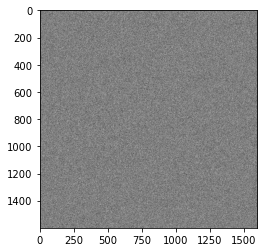

In [5]:
image_rgb = cv2.cvtColor(encry, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

<class 'numpy.ndarray'>
(1600, 1600)


True

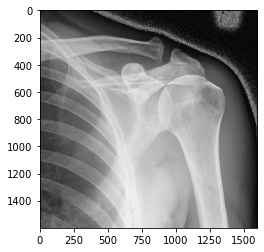

In [8]:
# Decryption of Diffusion
def reverse_diffusion(encrypted_image, chaotic, F):
    encrypted_image = encrypted_image.astype(np.float64)
    height, width = encrypted_image.shape
    decrypted_image = np.zeros_like(encrypted_image)
    key = [120, 200]
    bit = 2**32  # Scaling factor to scale chaotic value
    for i in range(height-1, -1, -1):
        for j in range(width-1, -1, -1):
            if i == 0 and j == 0:
                E_i = (encrypted_image[0][0] - (key[-1] + key[-2] + int((chaotic[i, j] * bit))) % F)
            elif i == 0 and j == 1:
                E_i = (encrypted_image[0][1] - (encrypted_image[i, j - 1] + key[-1] + int((chaotic[i, j] * bit))) % F)
            else:
                if j == 0:
                    E_i = (encrypted_image[i][j] - (encrypted_image[i - 1, width - 1] + encrypted_image[i - 1, width - 2] + int((chaotic[i, j] * bit))) % F)
                elif j == 1:
                    E_i = (encrypted_image[i][j] - (encrypted_image[i, j - 1] + encrypted_image[i - 1, width - 1] + int((chaotic[i, j] * bit))) % F)
                else:
                    E_i = (encrypted_image[i][j] - (encrypted_image[i, j - 1] + encrypted_image[i, j - 2] + int((chaotic[i, j] * bit))) % F)

            decrypted_image[i, j] = E_i
    return decrypted_image.astype(np.uint8)

def reverse_lscm_permutation(T, S, PM):
    P = np.zeros_like(T)
    M, N = T.shape
    e = np.zeros(N)
    l=c = np.zeros(N)
    for i in range(M):
        for j in range(N):
            x, y = PM[i][j]
            c[j] = T[x][y]
            e[j] = S[x][y]
        k = np.copy(c)
        v = np.argsort(e)
        for j in range(N):
            vi = v[j]
            x, y = PM[i][vi]
            P[x][y] = k[j]

    return P


# Reverse Arnold's Cat Map
def reverse_arnold_cat_map(image, iterations):
    height, width = image.shape

    # Apply the reverse map for the given number of iterations.
    for _ in range(iterations):
        new_image = np.zeros_like(image)
        for y in range(height):
            for x in range(width):
                new_x = (x - y) % width
                new_y = (y - new_x) % height
                new_image[new_y, new_x] = image[y, x]

        image = new_image

    return image


# Load the encrypted image
encrypted_image = cv2.imread('encrypted_image_5.jpg', cv2.IMREAD_GRAYSCALE)

# Reverse the diffusion
decrypted_image_diffusion = reverse_diffusion(encrypted_image, chaos, F)      # reversing of diffusion is working

# Assuming you have the permuted image, position matrix, chaotic map values, and the image size
decrypted_image_permutation = reverse_lscm_permutation(decrypted_image_diffusion, chaos, pm)              # reverse Permutation is working

# Reverse the Arnold's Cat Map
decrypted_image = reverse_arnold_cat_map(decrypted_image_permutation, 10)      # This also not working black image

# Show or save the decrypted image
#cv2.imwrite('decrypted_image.jpg', decrypted_image)


 # De-padding

# Determine the original height and width
original_height, original_width = img_p.shape

# Define the padding used to make the image square
m = max(original_height, original_width)
if m==original_height:
    original_image = decrypted_image[:,:m-(m-original_width)]
else:
    original_image = decrypted_image[:m-(m-original_height)]

# Reverse the padding by cropping the square image

# Print the type and shape of the original image
print(type(original_image))
print(original_image.shape)

image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

cv2.imwrite('decrypted.jpg', original_image)

In [7]:
img_rg = cv2.cvtColor(img_p, cv2.COLOR_BGR2RGB)
#encry_rgb = cv2.cvtColor(, cv2.COLOR_BGR2RGB)

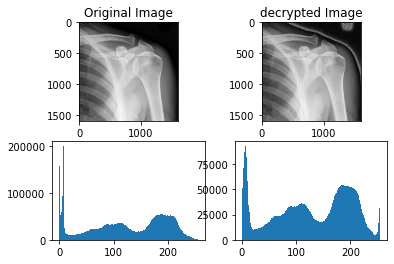

In [10]:
plt.subplot(2, 2, 1)
plt.imshow(img_rg)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(image_rgb)
plt.title("decrypted Image")

plt.subplot(2, 2, 3)
plt.hist(img_rg.ravel(), bins=256)

plt.subplot(2, 2, 4)
plt.hist(image_rgb.ravel(), bins=256)

plt.show() 